# Milestone 2 Sandbox

In [2]:
# Imports
import re
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

## Data Description

### 2022 Voter Turnout File

This CSV file contains Census Block-level data on the number of people that registered to vote and that actually voted for 11 elections held in Massachusetts including the 2020 presidential election. The data also contains several fields for the demographics at that specific Census Block, including age brackets, gender, ethnicity, language spoken, and estimated mean household income. Finally, there is also information on the number of voters affiliated with each party.

The geoid20 field contains the ID of the Census Block. We can truncate this value and group the data to conduct our analysis at the Block Group, Tract, or County level. We can utilize this hierarchy to spatially visualize our data at these levels of details as well.

In the file, there is a total of 107,292 observations and 395 columns (not including geoid20). All demographic fields except mean household income contain no null values. There are 21,210 Census Blocks missing mean household income values. Specifically, there are 728 blocks with at least one voter registered but with missing household income data. A total of 1,993 people live in blocks with missing household income data. For this milestone, we consider voter turnout data only from the 2020 presidential election. There are around 20,000 observations with missing values for the percentage voter turnout in the Census Block. These values are missing because there are no voters registered for the 2020 presidential election in those Census Blocks. There are 301 Census Blocks with > 0 total registrations but with 0 registrations specifically for the 2020 presidential election.

There are 14 rows in the voter turnout file without Census Block IDs, included as entries with 'NO BLOCK ASSIGNMENT' in their geoid20 column. Aggregated, there are 73,811 registered voters not assigned to a Census Block. This represents 1.60% of total registered voters (4,606,321) in Massachusetts. The distribution of gender and party affiliation seems to be the same in observations with valid Census Block IDs and those with 'NO BLOCK ASSIGNMENT'. Age distribution differ slightly, with higher portion of people aged 25-44 with 'NO BLOCK ASSIGNMENT' and higher portion of people aged 45-75 with valid Census Block IDs. 

#### Tabular Breakdown of 2022 Voter Turnout Data

<table>
    <tbody>
        <tr>
            <th>range</th><th>name</th><th>type</th><th>description</th><th>content</th>
        </tr>
         <tr>
            <td>0</td><td>geoid20</td><td>15 char string</td><td>15-character GEOID corresponding to 2020 Census Blocks, based on L2 geo-referencing of individual voter addresses</td><td>e.g.: 250277612003023</td>
        </tr>
         <tr>
            <td>1</td><td>total_reg</td><td>int</td><td>Count of total registered voters in the County, as geo-referenced by RDH from L2 voter file dated above</td><td></td>
        </tr>
         <tr>
            <td>2-11</td><td>age_*_*</td><td>int</td><td>count of people in age range in that census block</td><td>age_18_19, age_20_24, age_25_29, age_30_34, age_35_44, age_45_54, age_55_64, age_65_74, age_75_84, age_85over</td>
        </tr>
        <tr>
            <td>12-14</td><td>voters_gender_*</td><td>int</td><td>gender count</td><td>voters_gender_m, voters_gender_f, voters_gender_unknown</td>
        </tr>
        <tr>
            <td>15-24</td><td>party_*</td><td>int</td><td>count of voters registered in party</td><td>party_npp, party_dem, party_rep, party_lib, party_grn, party_con, party_ain, party_scl, party_oth, party_unk</td>
        </tr>
       <tr>
            <td>25-30</td><td>eth1_*</td><td>int</td><td>count of members in broad ethnic category</td><td>eth1_eur, eth1_hisp, eth1_aa, eth1_esa, eth1_oth, eth1_unk</td>
        </tr>
         <tr>
            <td>31-56</td><td>eth2_*</td><td>int</td><td>count of those in narrow ethnic category</td><td>eth2_euro, eth2_64, eth2_93, eth2_10, eth2_30, eth2_23, eth2_66, eth2_34, eth2_21, eth2_35, eth2_14, eth2_12, eth2_55, eth2_13, eth2_32, eth2_61, eth2_85, eth2_29, eth2_33, eth2_38, eth2_15, eth2_57, eth2_19, eth2_26, eth2_59, eth2_unk</td>
        </tr>
        <tr>
            <td>57-62</td><td>languages_description_*</td><td>int</td><td>count fluent in language</td><td>languages_description_English, languages_description_Spanish, languages_description_Portuguese, languages_description_Chinese, languages_description_Italian, languages_description_Vietnamese</td>
        </tr>
        <tr>
            <td>63</td><td>commercialdata_estimatedhhincomeamount_avg</td><td>num</td><td>Average of modeled data for estimated household income reported by L2 for individuals in the following ranges:  $1,000-$14,999/ $15,000-$24,999/ $25,000-$49,999/ $50,000-$74,999/ $75,000-$99,999/ $100,000-$124,999/ $125,000-$149,999/ $150,000-$174,999/ $175,000-$199,999/ $200,000-$249,999/ $250,000+</td><td></td>
        </tr>
        <tr>
            <td>SKIP</td><td>g20221108_*</td><td>num</td><td>not covering this election</td><td></td>
        </tr>
        <tr>
            <td>SKIP</td><td>p20220906_*</td><td>num</td><td>not covering this election</td><td></td>
        </tr>
         <tr>
            <td>SKIP</td><td>s20211214_*</td><td>num</td><td>not covering this election</td><td></td>
        </tr>
         <tr>
            <td>SKIP</td><td>s20211130_*</td><td>num</td><td>not covering this election</td><td></td>
        </tr>
         <tr>
            <td>SKIP</td><td>s20211102_*</td><td>num</td><td>not covering this election</td><td></td>
        </tr>
         <tr>
            <td>SKIP</td><td>s20210330_*</td><td>num</td><td>not covering this election</td><td></td>
        </tr>
         <tr>
            <td>SKIP</td><td>s20210302_*</td><td>num</td><td>not covering this election</td><td></td>
        </tr>
        <tr>
            <td>*</td><td>g20201103_*</td><td>num</td><td>2020 general election</td><td>g20201103_voted_all, g20201103_reg_all, g20201103_pct_voted_all, g20201103_voted_gender_m, g20201103_reg_gender_m, g20201103_pct_voted_gender_m, g20201103_voted_gender_f, g20201103_reg_gender_f, g20201103_pct_voted_gender_f, g20201103_voted_gender_unk, g20201103_reg_gender_unk, g20201103_pct_voted_gender_unk, g20201103_voted_eur, g20201103_reg_eur, g20201103_pct_voted_eur, g20201103_voted_hisp, g20201103_reg_hisp, g20201103_pct_voted_hisp, g20201103_voted_aa, g20201103_reg_aa, g20201103_pct_voted_aa, g20201103_voted_esa, g20201103_reg_esa, g20201103_pct_voted_esa, g20201103_voted_oth, g20201103_reg_oth, g20201103_pct_voted_oth, g20201103_voted_unk, g20201103_reg_unk, g20201103_pct_voted_unk</td>
        </tr>
        <tr>
            <td>SKIP</td><td>p20200901_*</td><td>num</td><td>not covering this election</td><td></td>
        </tr>
        <tr>
            <td>SKIP</td><td>s20200602_*</td><td>num</td><td>not covering this election</td><td></td>
        </tr>
        <tr>
            <td>SKIP</td><td>pp20200303_*</td><td>num</td><td>not covering this election - 2020 presidential primary</td><td></td>
        </tr>
    </tbody>
</table>

#### 2020 General Election Specific Columns

Columns that start with the string "g20201103_" are specific to the general election of in 2020. Below is a tabular breakdown of these columns. Other elections have corresponding columns that we are ignoring for this project. 


<table>
    <tbody>
        <tr>
            <th>name</th><th>type</th><th>null values</th><th>description</th>
        </tr>
         <tr>
           <td>g20201103_voted_all</td><td>int</td><td>0</td><td>count of all voters who voted</td>
        </tr>
         <tr>
           <td>g20201103_reg_all</td><td>int</td><td>0</td><td>count of voters registered on or before: 2020-11-03  </td>
        </tr>
         <tr>
           <td>g20201103_pct_voted_all</td><td>num</td><td>20644</td><td>Percent of voters registered on or before 2020-11-03 and who voted in: general_2020_11_03</td>
        </tr>
         <tr>
           <td>g20201103_voted_gender_m</td><td>int</td><td>0</td><td>Count of voters who voted in the following election: general_2020_11_03, L2 Gender: Male</td>
        </tr>
         <tr>
           <td>g20201103_reg_gender_m</td><td>int</td><td>0</td><td>Count of voters registered on or before: 2020-11-03, L2 Gender: Male</td>
        </tr>
         <tr>
           <td>g20201103_pct_voted_gender_m</td><td>num</td><td>21957</td><td>Percent of voters registered on or before 2020-11-03 and who voted in: general_2020_11_03, L2 Gender: Male</td>
        </tr>
         <tr>
           <td>g20201103_voted_gender_f</td><td>int</td><td>0</td><td>Count of voters who voted in the following election: general_2020_11_03, L2 Gender: Female</td>
        </tr>
         <tr>
           <td>g20201103_reg_gender_f</td><td>int</td><td>0</td><td>Count of voters registered on or before: 2020-11-03, L2 Gender: Female</td>
        </tr>
         <tr>
           <td>g20201103_pct_voted_gender_f</td><td>num</td><td>21856</td><td>Percent of voters registered on or before 2020-11-03 and who voted in: general_2020_11_03, L2 Gender: Female</td>
        </tr>
         <tr>
           <td>g20201103_voted_gender_unk</td><td>int</td><td>0</td><td>Count of voters who voted in the following election: general_2020_11_03, L2 Gender: Unknown</td>
        </tr>
         <tr>
           <td>g20201103_reg_gender_unk</td><td>int</td><td>0</td><td>Count of voters registered on or before: 2020-11-03, L2 Gender: Unknown</td>
        </tr>
         <tr>
           <td>g20201103_pct_voted_gender_unk</td><td>num</td><td>95857</td><td>Percent of voters registered on or before 2020-11-03 and who voted in: general_2020_11_03, L2 Gender: Unknown</td>
        </tr>
         <tr>
           <td>g20201103_voted_eur</td><td>int</td><td>0</td><td>Count of voters who voted in the following election: general_2020_11_03, L2 Race or Ethnicity: European</td>
        </tr>
         <tr>
           <td>g20201103_reg_eur</td><td>int</td><td>0</td><td>Count of voters registered on or before: 2020-11-03, L2 Race or Ethnicity: European</td>
        </tr>
         <tr>
           <td>g20201103_pct_voted_eur</td><td>num</td><td>21826</td><td>Percent of voters registered on or before 2020-11-03 and who voted in: general_2020_11_03, L2 Race or Ethnicity: European</td>
        </tr>
         <tr>
           <td>g20201103_voted_hisp</td><td>int</td><td>0</td><td>Count of voters who voted in the following election: general_2020_11_03, L2 Race or Ethnicity: Hispanic and Portuguese</td>
        </tr>
         <tr>
           <td>g20201103_reg_hisp</td><td>int</td><td>0</td><td>Count of voters registered on or before: 2020-11-03, L2 Race or Ethnicity: Hispanic and Portuguese</td>
        </tr>
         <tr>
           <td>g20201103_pct_voted_hisp</td><td>num</td><td>52848</td><td>Percent of voters registered on or before 2020-11-03 and who voted in: general_2020_11_03, L2 Race or Ethnicity: Hispanic and Portuguese</td>
        </tr>
         <tr>
           <td>g20201103_voted_aa</td><td>int</td><td>0</td><td>Count of voters who voted in the following election: general_2020_11_03, L2 Race or Ethnicity: Likely African-American</td>
        </tr>
         <tr>
           <td>g20201103_reg_aa</td><td>int</td><td>0</td><td>Count of voters registered on or before: 2020-11-03, L2 Race or Ethnicity: Likely African-American</td>
        </tr>
         <tr>
           <td>g20201103_pct_voted_aa</td><td>num</td><td>85886</td><td>Percent of voters registered on or before 2020-11-03 and who voted in: general_2020_11_03, L2 Race or Ethnicity: Likely African-American</td>
        </tr>
         <tr>
           <td>g20201103_voted_esa</td><td>int</td><td>0</td><td>Count of voters who voted in the following election: general_2020_11_03, L2 Race or Ethnicity: East and South Asian</td>
        </tr>
         <tr>
           <td>g20201103_reg_esa</td><td>int</td><td>0</td><td>Count of voters registered on or before: 2020-11-03, L2 Race or Ethnicity: East and South Asian</td>
        </tr>
         <tr>
           <td>g20201103_pct_voted_esa</td><td>num</td><td>72867</td><td>Percent of voters registered on or before 2020-11-03 and who voted in: general_2020_11_03, L2 Race or Ethnicity: East and South Asian</td>
        </tr>
         <tr>
           <td>g20201103_voted_oth</td><td>int</td><td>0</td><td>Count of voters who voted in the following election: general_2020_11_03, L2 Race or Ethnicity: Other</td>
        </tr>
         <tr>
           <td>g20201103_reg_oth</td><td>int</td><td>0</td><td>Count of voters registered on or before: 2020-11-03, L2 Race or Ethnicity: Other</td>
        </tr>
         <tr>
           <td>g20201103_pct_voted_oth</td><td>num</td><td>71341</td><td>Percent of voters registered on or before 2020-11-03 and who voted in: general_2020_11_03, L2 Race or Ethnicity: Other</td>
        </tr>
         <tr>
           <td>g20201103_voted_unk</td><td>int</td><td>0</td><td>Count of voters who voted in the following election: general_2020_11_03, L2 Race or Ethnicity: Unknown</td>
        </tr>
         <tr>
           <td>g20201103_reg_unk</td><td>int</td><td>0</td><td>Count of voters registered on or before: 2020-11-03, L2 Race or Ethnicity: Unknown</td>
        </tr>
         <tr>
           <td>g20201103_pct_voted_unk</td><td>num</td><td>40285</td><td>Percent of voters registered on or before 2020-11-03 and who voted in: general_2020_11_03, L2 Race or Ethnicity: Unknown</td>
        </tr>
    </tbody>
</table>


### 2020 Census Block Shapefile

This Shapefile contains spatial data for Census Blocks. It contains 107,278 observations and 384 columns (not including GEOID20). For now, the shapefile is used to visualize the data on a map. With the exception of the 14 records with 'NO BLOCK ASSIGNMENT', the geoid20 field from the CSV perfectly matches with the GEOID20 field from the Shapefile.

The data dictionary for the PL 94-171 data can be found [here](https://www2.census.gov/programs-surveys/decennial/2020/technical-documentation/complete-tech-docs/summary-file/2020Census_PL94_171Redistricting_StatesTechDoc_English.pdf). In addition to the data included with the Voter Turnout file, the shapefile contains data for the geographic hierarchy that the Census Block fits into (such as the CSA), information on land and water area, and more detailed race and ethnicity information. As of right now, we have no plans to make use of the more detailed geographic or demographic information in the shapefile. We will use the shapefile for visualization purposes and possibly to examine spatial autocorrelation of our predictors and response variables.

## Potential Data Issues

### Data Missingness

There are two sources of missingness in our voter turnout data:
1. The 14 observations with the 'NO BLOCK ASSIGNMENT' values (73,811 people or 1.6% of the total number of voters).
2. Missing average household income information for 728 blocks (1,993 people).

### Data Imbalance

### Data Scaling 

The only units that we will be using is counts and ratios, where ratios are the minority of data. We may consider scaling if relating counts to ratios. However, we will initially be relating coutns to other counts, so do not anticipate this to be an issue. 
 

## Solutions to Data Issues

## Supporting Code

### 2022 Voter Turnout File

#### 1. Load in data and define relevant columns

In [3]:
# [INSTRUCTIONS]: go into /data and unzip both folders; the .gitignore prevents the unzipped contents from being pushed to repo
voter_df = pd.read_csv('../data/MA_l2_2022stats_2020block/MA_l2_2022stats_2020block.csv', low_memory=False).set_index('geoid20')
voter_df.shape

(107292, 395)

In [4]:
# Group demographic columns together
registered = ['total_reg']
age = ['age_18_19', 'age_20_24', 'age_25_29','age_30_34','age_35_44', 'age_45_54', 'age_55_64', 'age_65_74','age_75_84', 'age_85over']
gender = [ 'voters_gender_m', 'voters_gender_f', 'voters_gender_unknown'] 
party = ['party_npp', 'party_dem', 'party_rep','party_lib', 'party_grn', 'party_con', 'party_ain', 'party_scl','party_oth', 'party_unk']
ethnicity = ['eth1_eur', 'eth1_hisp', 'eth1_aa',
                'eth1_esa', 'eth1_oth', 'eth1_unk', 'eth2_euro', 'eth2_64',
                'eth2_93', 'eth2_10', 'eth2_30', 'eth2_23', 'eth2_66', 'eth2_34',
                'eth2_21', 'eth2_35', 'eth2_14', 'eth2_12', 'eth2_55', 'eth2_13',
                'eth2_32', 'eth2_61', 'eth2_85', 'eth2_29', 'eth2_33', 'eth2_38',
                'eth2_15', 'eth2_57', 'eth2_19', 'eth2_26', 'eth2_59', 'eth2_unk']
languages = ['languages_description_english', 'languages_description_spanish',
                'languages_description_portuguese',
                'languages_description_chinese', 'languages_description_italian',
                'languages_description_vietnamese', 'languages_description_other',
                'languages_description_unknown']
income = ['commercialdata_estimatedhhincomeamount_avg']

# Group variables related to the 2020 presidential election
# print(list(voter_df.filter(like='g20201103_').columns))
presidential_2020 = ['g20201103_voted_all', 'g20201103_reg_all', 'g20201103_pct_voted_all',
       'g20201103_voted_gender_m', 'g20201103_reg_gender_m',
       'g20201103_pct_voted_gender_m', 'g20201103_voted_gender_f',
       'g20201103_reg_gender_f', 'g20201103_pct_voted_gender_f',
       'g20201103_voted_gender_unk', 'g20201103_reg_gender_unk',
       'g20201103_pct_voted_gender_unk', 'g20201103_voted_eur',
       'g20201103_reg_eur', 'g20201103_pct_voted_eur', 'g20201103_voted_hisp',
       'g20201103_reg_hisp', 'g20201103_pct_voted_hisp', 'g20201103_voted_aa',
       'g20201103_reg_aa', 'g20201103_pct_voted_aa', 'g20201103_voted_esa',
       'g20201103_reg_esa', 'g20201103_pct_voted_esa', 'g20201103_voted_oth',
       'g20201103_reg_oth', 'g20201103_pct_voted_oth', 'g20201103_voted_unk',
       'g20201103_reg_unk', 'g20201103_pct_voted_unk']

#### 2. Check for null values in data


<table>
    <tbody>
        <tr>
            <th>range</th><th>name</th><th>null values</th>
        </tr>
         <tr>
            <td>0</td><td>geoid20</td><td>0 </td>
        </tr>
         <tr>
            <td>1</td><td>total_reg</td><td>0</td>
        </tr>
         <tr>
            <td>2-11</td><td>age_*_*</td><td>0</td>
        </tr>
        <tr>
            <td>12-14</td><td>voters_gender_*</td><td>0</td>
        </tr>
        <tr>
            <td>15-24</td><td>party_*</td><td>0</td>
        </tr>
       <tr>
            <td>25-30</td><td>eth1_*</td><td>0</td>
        </tr>
         <tr>
            <td>31-56</td><td>eth2_*</td><td>0</td>
        <tr>
            <td>57-62</td><td>languages_description_*</td><td>0</td>
        </tr>
        <tr>
            <td>63</td><td>commercialdata_estimatedhhincomeamount_avg</td><td>21210</td>
        </tr>
        <tr>
            <td>...</td><td>g20201103_*</td><td>505367=20644+21957+21856+95857+21826+52848+85886+72867+71341+40285</td>
        </tr>
    </tbody>
</table>

In [5]:
# Report null values for registered
voter_df[registered].isna().sum()

total_reg    0
dtype: int64

In [6]:
# Report null values for age
voter_df[age].isna().sum()

age_18_19     0
age_20_24     0
age_25_29     0
age_30_34     0
age_35_44     0
age_45_54     0
age_55_64     0
age_65_74     0
age_75_84     0
age_85over    0
dtype: int64

In [7]:
# Report null values for gender
voter_df[gender].isna().sum()

voters_gender_m          0
voters_gender_f          0
voters_gender_unknown    0
dtype: int64

In [8]:
# Report null values for gender
voter_df[party].isna().sum()

party_npp    0
party_dem    0
party_rep    0
party_lib    0
party_grn    0
party_con    0
party_ain    0
party_scl    0
party_oth    0
party_unk    0
dtype: int64

In [9]:
# Report null values for gender
voter_df[ethnicity].isna().sum()

eth1_eur     0
eth1_hisp    0
eth1_aa      0
eth1_esa     0
eth1_oth     0
eth1_unk     0
eth2_euro    0
eth2_64      0
eth2_93      0
eth2_10      0
eth2_30      0
eth2_23      0
eth2_66      0
eth2_34      0
eth2_21      0
eth2_35      0
eth2_14      0
eth2_12      0
eth2_55      0
eth2_13      0
eth2_32      0
eth2_61      0
eth2_85      0
eth2_29      0
eth2_33      0
eth2_38      0
eth2_15      0
eth2_57      0
eth2_19      0
eth2_26      0
eth2_59      0
eth2_unk     0
dtype: int64

In [10]:
# Report null values for income
voter_df[income].isna().sum()

commercialdata_estimatedhhincomeamount_avg    21210
dtype: int64

In [11]:
print(f'There are {voter_df[(voter_df[income[0]].isna()) & (voter_df['total_reg'] > 0)].shape[0]} blocks with at least one voter registered but with missing household income data.')
print(f'A total of {voter_df[(voter_df[income[0]].isna()) & (voter_df['total_reg'] > 0)]['total_reg'].sum():,d} people live in blocks with missing household income data.')

There are 728 blocks with at least one voter registered but with missing household income data.
A total of 1,993 people live in blocks with missing household income data.


In [12]:
# Report null values for gender
voter_df[languages].isna().sum()

languages_description_english       0
languages_description_spanish       0
languages_description_portuguese    0
languages_description_chinese       0
languages_description_italian       0
languages_description_vietnamese    0
languages_description_other         0
languages_description_unknown       0
dtype: int64

In [13]:
# Report null values for presidential voter stats
# these percent columns are where the null values are dominating 
tmp = voter_df[presidential_2020].isna().sum()
tmp[tmp>0]

g20201103_pct_voted_all           20644
g20201103_pct_voted_gender_m      21957
g20201103_pct_voted_gender_f      21856
g20201103_pct_voted_gender_unk    95857
g20201103_pct_voted_eur           21826
g20201103_pct_voted_hisp          52848
g20201103_pct_voted_aa            85886
g20201103_pct_voted_esa           72867
g20201103_pct_voted_oth           71341
g20201103_pct_voted_unk           40285
dtype: int64

#### 3. Looking into Missingness

In [29]:
# 
voter_df.head().index

Index(['250277614022079', '250277614022078', '250277614022077',
       '250277614022076', '250277614022075'],
      dtype='object', name='geoid20')

#### 4. Initial investigation of data

In [14]:
# Show Census Blocks with more than 0 total registrations but with 0 registrations in the 2020 presidential elections
voter_df[['total_reg','g20201103_voted_all','g20201103_reg_all']][(voter_df['total_reg'] > 0) & (voter_df['g20201103_reg_all'] == 0)]

,total_reg,g20201103_voted_all,g20201103_reg_all
geoid20,,,
250277614022049,1,0,0
250277581041030,1,0,0
250277441022004,1,0,0
250277382023021,1,0,0
250277352001024,1,0,0
...,...,...,...
250010112002020,1,0,0
250010110023043,2,0,0
250010107004008,1,0,0


In [15]:
# Filter dataset to show entries without block IDs
no_block_df = voter_df[voter_df.index.str.contains('NO BLOCK',na=False)]
no_block_df.shape

(14, 395)

In [16]:
valid_df = voter_df.drop(no_block_df.index)
valid_df.shape

(107278, 395)

In [17]:
# Total number of people without block assignments
print(f'There are {no_block_df[registered].sum().iloc[0]:,d} registered voters not assigned to a Census Block.')
print(f'This represents {no_block_df[registered].sum().iloc[0]/voter_df[registered].sum().iloc[0]:.2%} ({voter_df[registered].sum().iloc[0]:,d}) of total registered voters in Massachusetts.')

There are 73,811 registered voters not assigned to a Census Block.
This represents 1.60% (4,606,321) of total registered voters in Massachusetts.


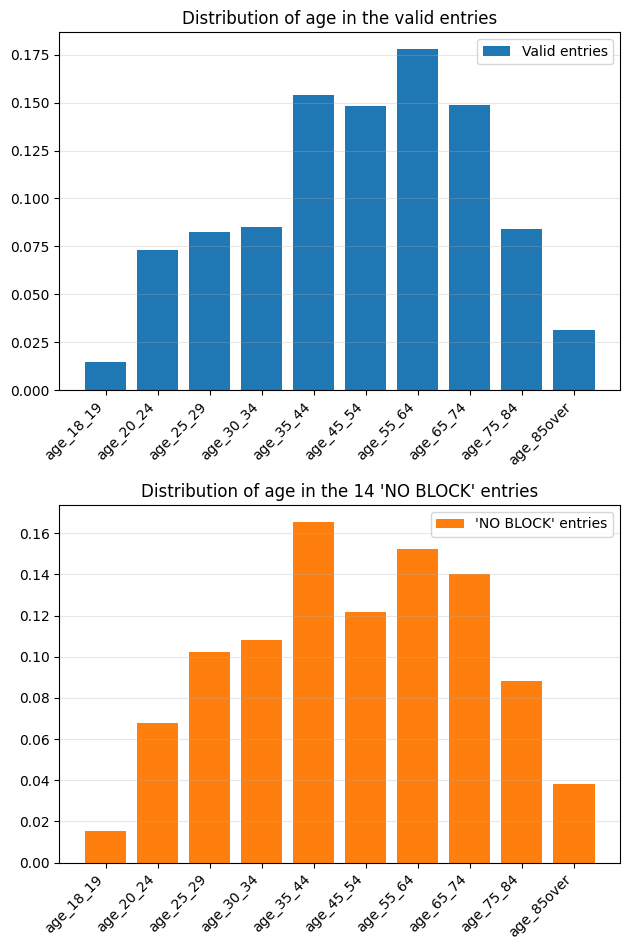

In [18]:
# Age distribution for those block assignments
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(6.4,4.8*2))
ax1.bar(age, valid_df[age].sum() / valid_df[registered].sum().iloc[0], color='C0', label='Valid entries')
ax1.set_xticks(ticks=age, labels=age, rotation=45, ha='right')
ax1.set_title('Distribution of age in the valid entries')
ax1.grid(axis='y', alpha=0.3)
ax1.legend()

# Age distribution for those without block assignments
ax2.bar(age, no_block_df[age].sum() / no_block_df[registered].sum().iloc[0], color='C1', label='\'NO BLOCK\' entries')
ax2.set_xticks(ticks=age, labels=age, rotation=45, ha='right')
ax2.set_title('Distribution of age in the 14 \'NO BLOCK\' entries')
ax2.grid(axis='y', alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

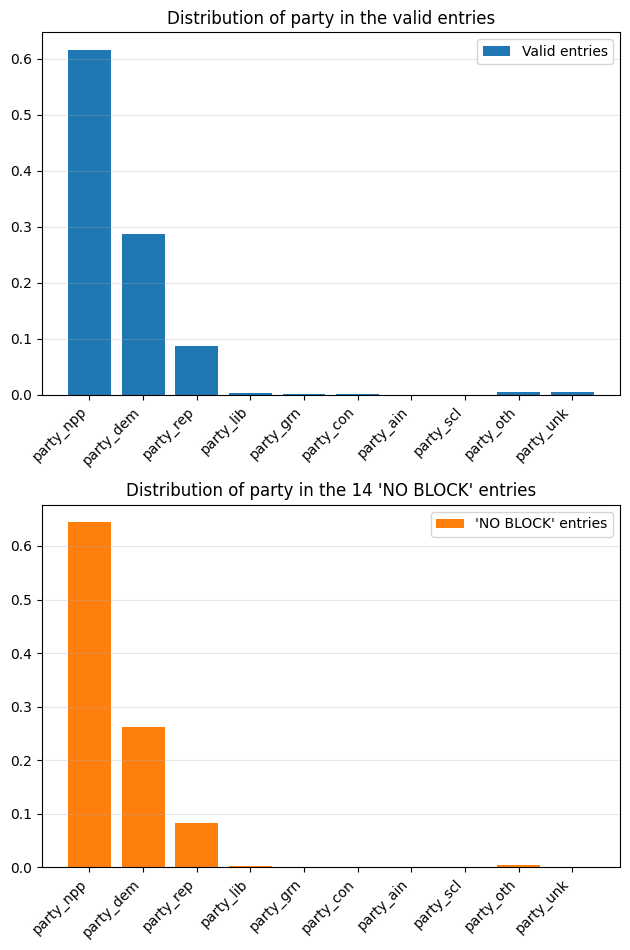

In [19]:
# party distribution for those block assignments
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(6.4,4.8*2))
ax1.bar(party, valid_df[party].sum() / valid_df[registered].sum().iloc[0], color='C0', label='Valid entries')
ax1.set_xticks(ticks=party, labels=party, rotation=45, ha='right')
ax1.set_title('Distribution of party in the valid entries')
ax1.grid(axis='y', alpha=0.3)
ax1.legend()

# party distribution for those without block assignments
ax2.bar(party, no_block_df[party].sum() / no_block_df[registered].sum().iloc[0], color='C1', label='\'NO BLOCK\' entries')
ax2.set_xticks(ticks=party, labels=party, rotation=45, ha='right')
ax2.set_title('Distribution of party in the 14 \'NO BLOCK\' entries')
ax2.grid(axis='y', alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

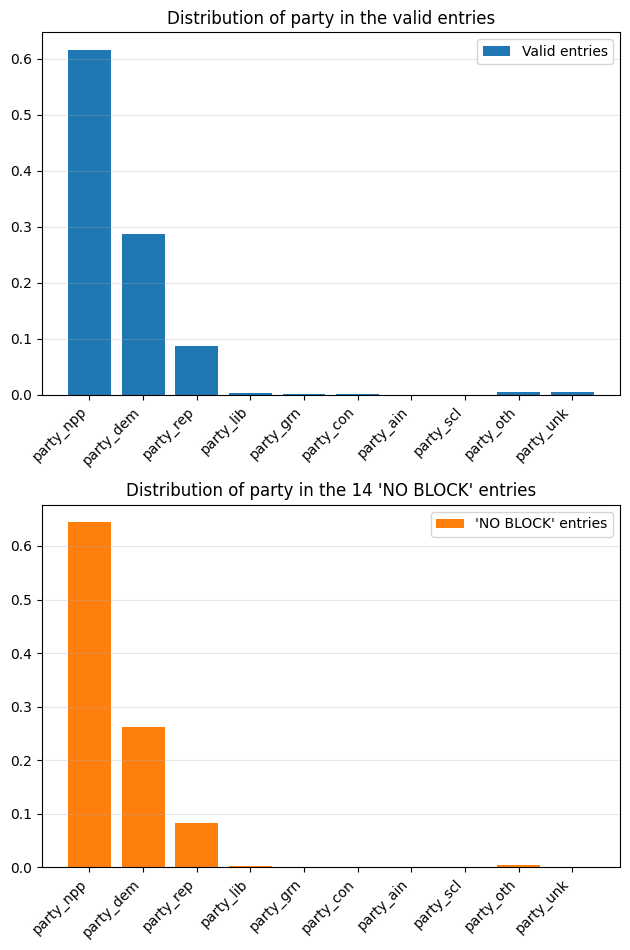

In [20]:
# party distribution for those block assignments
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(6.4,4.8*2))
ax1.bar(party, valid_df[party].sum() / valid_df[registered].sum().iloc[0], color='C0', label='Valid entries')
ax1.set_xticks(ticks=party, labels=party, rotation=45, ha='right')
ax1.set_title('Distribution of party in the valid entries')
ax1.grid(axis='y', alpha=0.3)
ax1.legend()

# party distribution for those without block assignments
ax2.bar(party, no_block_df[party].sum() / no_block_df[registered].sum().iloc[0], color='C1', label='\'NO BLOCK\' entries')
ax2.set_xticks(ticks=party, labels=party, rotation=45, ha='right')
ax2.set_title('Distribution of party in the 14 \'NO BLOCK\' entries')
ax2.grid(axis='y', alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

In [21]:
# Report the number of elections with data
elections = np.unique([col[:10].strip('_') for col in voter_df.columns if re.search(r'\w\d{8,9}',col[:10])])
print(f'There are {len(elections)} elections present in the dataset.')

There are 11 elections present in the dataset.


### 2020 Census Blocks Shapefile

#### 1. Load in data and examine

In [22]:
# Read in the shapefile
blocks_gdf = gpd.read_file('../data/ma_pl2020_b/ma_pl2020_b.shp')
blocks_gdf.shape

(107278, 385)

<Axes: >

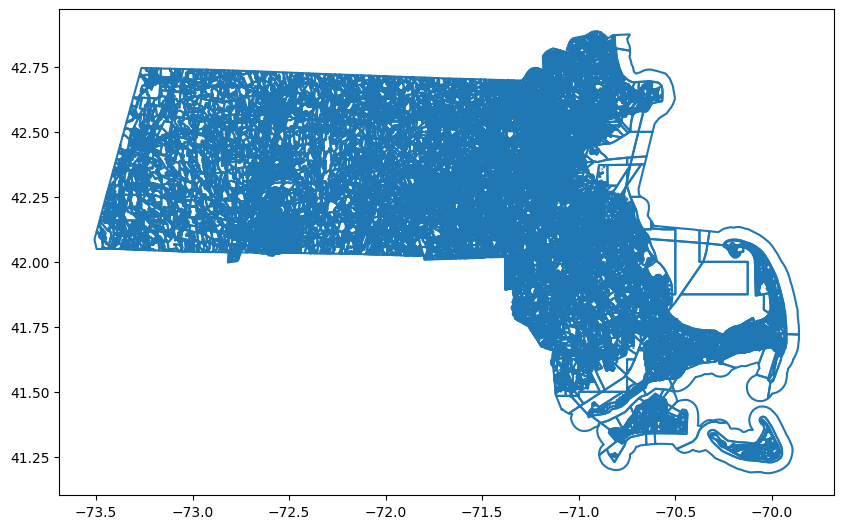

In [23]:
blocks_gdf.boundary.plot(figsize=(10,10))

In [24]:
# Print first 5 rows
blocks_gdf.head()

,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,NAME20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,...,P0050002,P0050003,P0050004,P0050005,P0050006,P0050007,P0050008,P0050009,P0050010,geometry
0,25,003,935300,3056,250039353003056,Block 3056,G5040,S,5818,0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-73.10996 42.69902, -73.10976 42.699..."
1,25,003,920102,1019,250039201021019,Block 1019,G5040,S,28305844,22648,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-73.23809 42.66205, -73.23797 42.662..."
2,25,003,926100,1041,250039261001041,Block 1041,G5040,S,228251,31171,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-73.41092 42.13063, -73.41082 42.131..."
3,25,003,931100,2021,250039311002021,Block 2021,G5040,S,63041,0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-73.08619 42.70946, -73.08607 42.709..."
4,25,003,926100,1071,250039261001071,Block 1071,G5040,S,45386,0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-73.32652 42.09883, -73.32633 42.098..."


In [25]:
# Merge the two files together with an outer join, see if any blocks are left out in each dataset
shape_blocks = blocks_gdf[['GEOID20']].copy()
shape_blocks['GEOID20'] = shape_blocks['GEOID20'].astype(str)
csv_blocks = voter_df.reset_index()[['geoid20']].copy()
csv_blocks['geoid20'] = csv_blocks['geoid20'].astype(str)
outer_merge = pd.merge(left=shape_blocks, right=csv_blocks, how='outer', left_on='GEOID20', right_on='geoid20')

In [26]:
# Confirm that discrepancy of 14 blocks are 'NO BLOCK ASSIGNMENT' entries
outer_merge[outer_merge['GEOID20'] != outer_merge['geoid20']]

,GEOID20,geoid20
0,NaN,001 - NO BLOCK ASSIGNMENT
1,NaN,003 - NO BLOCK ASSIGNMENT
2,NaN,005 - NO BLOCK ASSIGNMENT
3,NaN,007 - NO BLOCK ASSIGNMENT
4,NaN,009 - NO BLOCK ASSIGNMENT
5,NaN,011 - NO BLOCK ASSIGNMENT
6,NaN,013 - NO BLOCK ASSIGNMENT
7,NaN,015 - NO BLOCK ASSIGNMENT
8,NaN,017 - NO BLOCK ASSIGNMENT
9,NaN,019 - NO BLOCK ASSIGNMENT
